## Школа "Моделирование и анализ сетей", 17-20 октября 2019
**Команда:** Александр Лобашев, Даша Ким
**Google Colab**: bit.ly/prediction_colab

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx 
import pandas as pd
import random
from tqdm import tqdm_notebook
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau

In [2]:
G = nx.read_edgelist('../data/raw/ca-netscience.txt', nodetype=int)

In [3]:
def localized_group(G,group_size=20):
    nodes=list(G.nodes())
    a=np.random.choice(nodes, size=1, replace=False)[0]
    neighbors=list(G[a])
    for node in neighbors:
        neighbors=neighbors+list(G[node])
    s=list(set(neighbors))
    if(len(s)>=group_size):
        group=list(np.random.choice(s, size=group_size, replace=False))
        return group
    else:
        return s
    
def activated_nodes(G,active, rate=0.12): # return list of activated nodes
    targets=[]
    for node in active:
        targets=targets+list(G[node]) # list of neighbors
           
    if (len(targets)>0):
        s=np.random.binomial(1, rate, len(targets))
        activated=list(np.array(targets)[np.nonzero(s)])
        if (len(activated)>0):
            return activated
        else: 
            return False
    else:
        return False
    
def spread(G, spreader, steps=100):
    active=spreader #initial spreader
    visited=[]
    t=0
    while(t<steps):
        t=t+1
        s=activated_nodes(G,active)
        active=[]
        if (s==False):
            t=steps
        else:
            for node in s:
                if (node not in visited):
                    active.append(node)
                    visited.append(node)
            if (len(active)==0):
                t=steps
    return (visited)

def fraction(list1,list2):
    return len(set(list1) & set(list2))/len(list1)

def spreading_ability(G,node, targets,num=2000):
    s=np.zeros(num)
    for i in range(num):
        s[i]=fraction(targets,(spread(G, [node])))
    return sum(s)/num

In [4]:
pos = nx.spring_layout(G, iterations=200)
nodes = list(G.nodes())

def walk_and_save(G, num_samples=50, draw=False, save=False):
    target_list, spreading_abilities = [], []
    for i in tqdm_notebook(range(num_samples), desc='Generating sample...'):
        targets = localized_group(G, group_size=20)
        target_list.append(targets)
        
        s = []
        for node in nodes:
            a = spreading_ability(G, node, targets)
            s.append(a)
        spreading_abilities.append(s)
        
        if draw:
            net = nx.draw(G, pos, node_size=25, with_labels=False)
            net = nx.draw_networkx_nodes(G, pos,
                                   nodelist=targets,
                                   node_color='b',node_size=25)
            net.savefig(fname='../viz/{}.png'.format(i))
            
        if save:
            df_t = pd.DataFrame(columns=['target'])
            df_t['target'] = targets
            df_t.to_csv('../data/raw/targets_{}.csv'.format(i), index=False)

            df_sa = pd.DataFrame(columns=['node', 'spreading_ability'])
            df_sa['node'] = list(np.array(nodes)[np.nonzero(s)])
            df_sa['spreading_ability'] = list(np.array(s)[np.nonzero(s)])
            df_sa.to_csv('../data/raw/spreading_{}.csv'.format(i), index=False)
        
    return target_list, spreading_abilities

In [5]:
def draw_(Gk, pos, metrics, rescale_metrics=True):
    def rescale_log(weigths_list):
        cutoff = 1e-20
        for _ in range(len(weigths_list)):
            if weigths_list[_] < cutoff:
                weigths_list[_] = cutoff
        return 1/(np.log(np.array(weigths_list)))
    if rescale_metrics:
        metrics = rescale_log(metrics)
    norm = 1000/np.max(metrics)
    options = {
    'with_labels':True,
    'node_color': [v * norm for v in metrics],
    'node_size': [v * norm for v in metrics],
    'line_color': 'grey',
    'linewidths': 0.5,
    'width': 0.5,
    'cmap': 'YlGnBu',
    'with_labels':True
    }
    nx.draw(Gk, pos, **options)


In [52]:
def get_exp_decay(G, targets):
    # exp decay
    weights = []
    for n in nodes:
        cumulative_weight = []
        for tar in targets:
            weight = nx.shortest_path_length(G, source=tar, target=n)
            cumulative_weight.append(weight)
        weights.append(np.exp(-sum(cumulative_weight)/len(targets)))
#         weights.append(sum(np.exp(-np.array(cumulative_weight)))/len(targets))
    return weights

In [20]:
def evaluate(pred, s):
    pearson = pearsonr(pred, s)[0]
    spearman = spearmanr(pred, s)[0]
    ktau = kendalltau(pred, s)[0]
    return pearson, spearman, ktau
    
def print_results(res):
    print("Pearson correlation: {}".format(round(res[0], ndigits=4)))
    print("Spearman correlation: {}".format(round(res[1], ndigits=4)))
    print("Kendall rank correlation coeff: {}".format(round(res[2], ndigits=4)))
    print()

In [8]:
closeness = np.array(list(nx.closeness_centrality(G).values()))
katz = np.array(list(nx.katz_centrality_numpy(G).values()))
betweenness = np.array(list(nx.betweenness_centrality(G).values()))
eigenvector = np.array(list(nx.eigenvector_centrality(G).values()))
pagerank = np.array(list(nx.pagerank(G, alpha=0.85).values()))
flow = list(nx.approximate_current_flow_betweenness_centrality(G).values())
exp_deviation_closeness = closeness/np.mean(closeness)

res = []
sample_t, sample_s = walk_and_save(G, num_samples=10, draw=False)

In [67]:
degrees = np.array([d for n, d in G.degree()])

In [106]:
res = []
w = []
for targets, spreading in tqdm_notebook(zip(sample_t, sample_s)):
    weights = get_exp_decay(G, targets)
    pred = np.array(weights)*(1+betweenness+eigenvector+pagerank+flow+0.03*degrees)
    res.append(evaluate(pred, spreading))
    w.append(weights)
res = np.array(res)

In [107]:
np.mean(res, axis=0)

array([0.96068017, 0.92021442, 0.79546043])

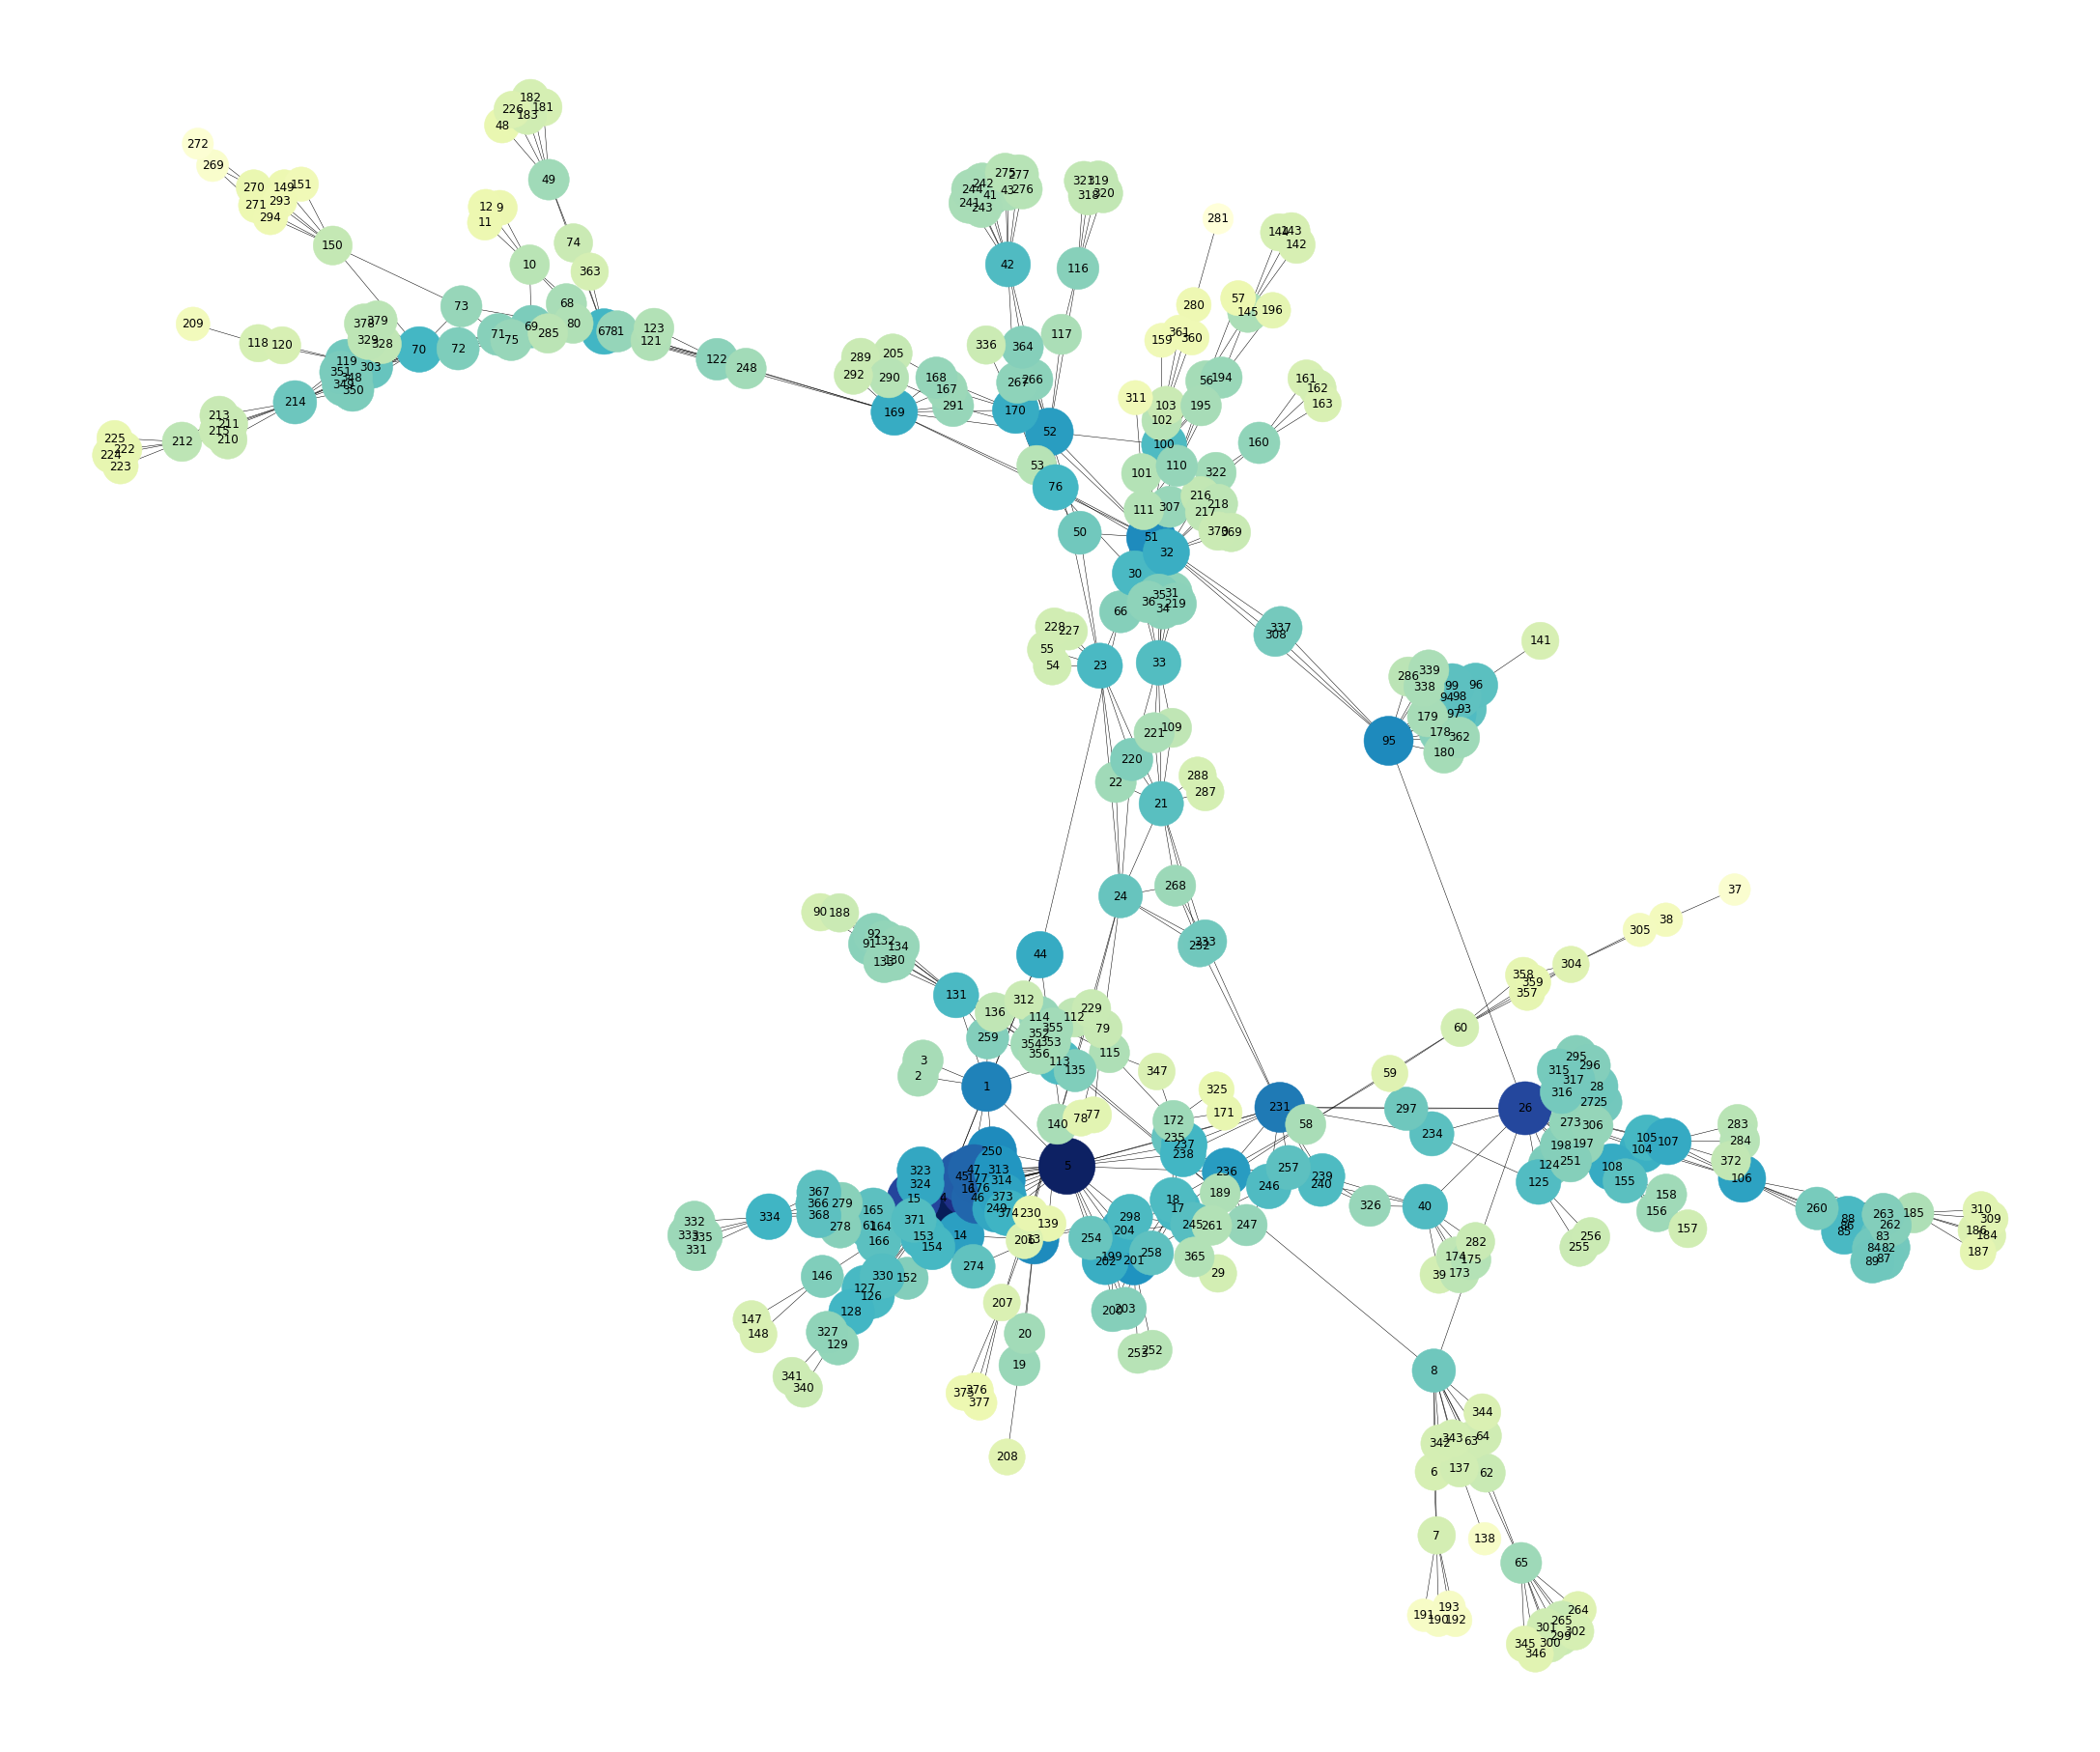

In [108]:
plt.figure(figsize=(30,25))
im1 = draw_(G, pos, np.mean(sample_s, axis=0))

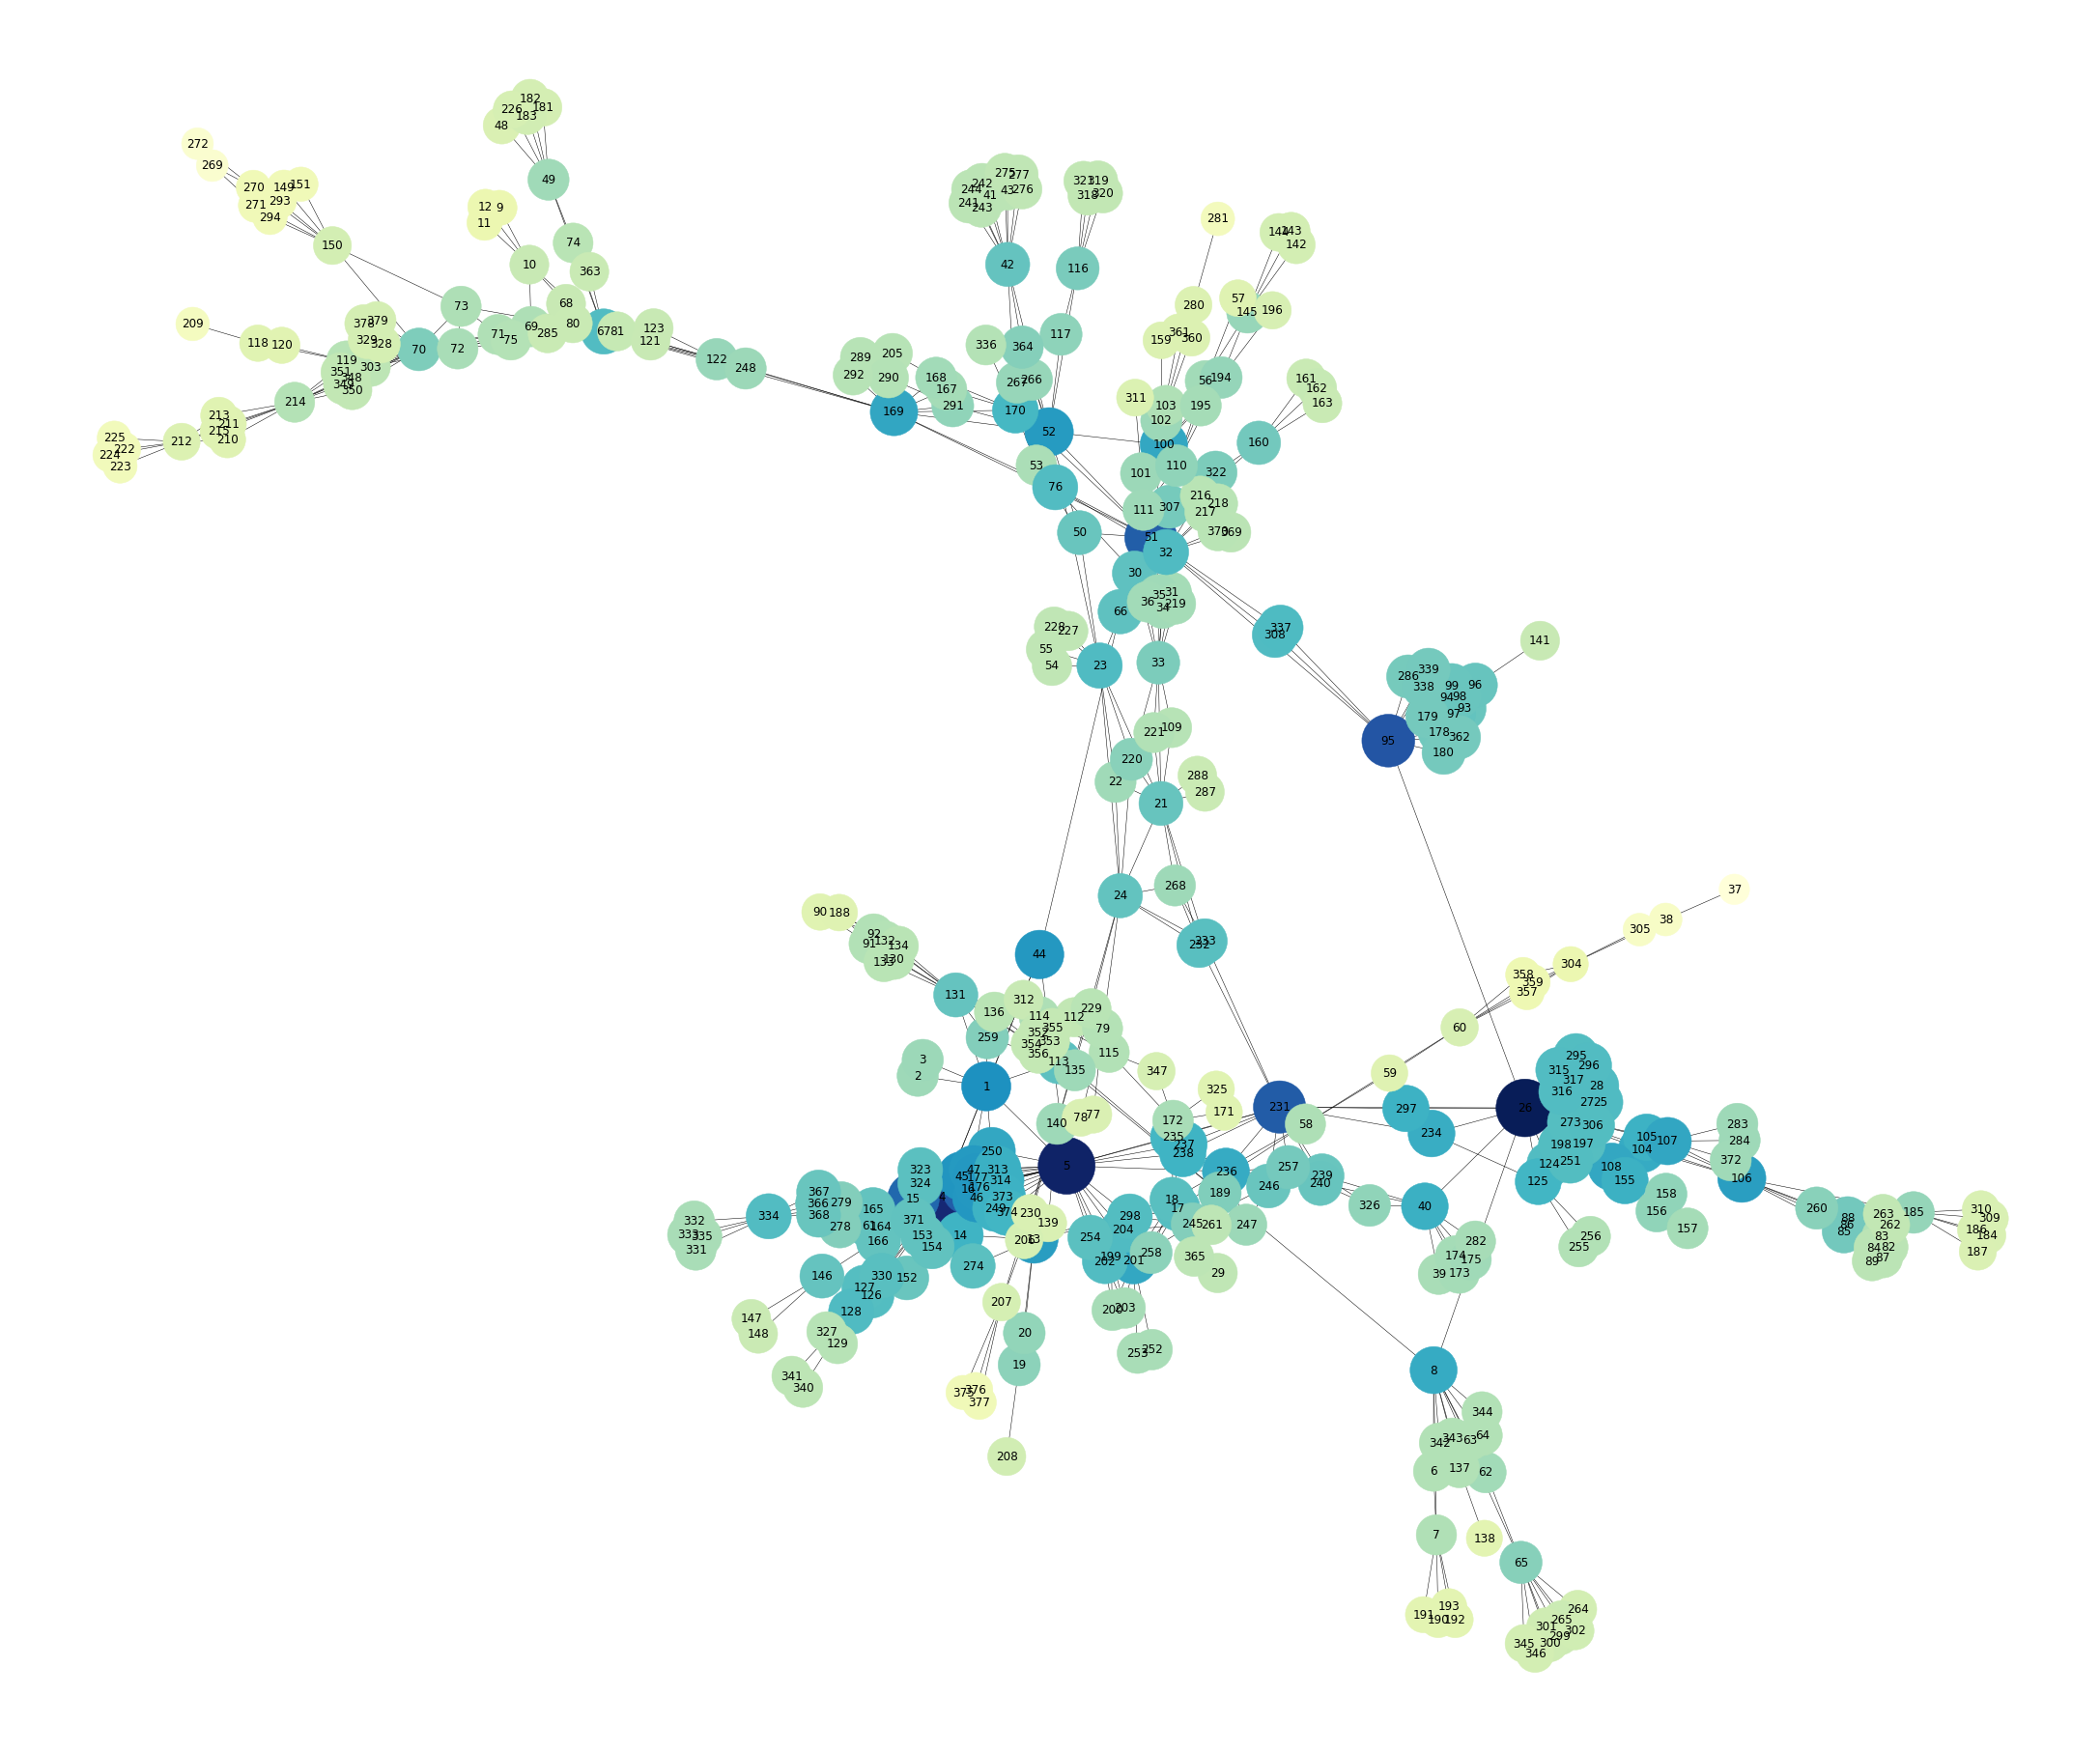

In [109]:
plt.figure(figsize=(30,25))
im2 = draw_(G, pos, np.mean(w, axis=0)*(1+betweenness+eigenvector))

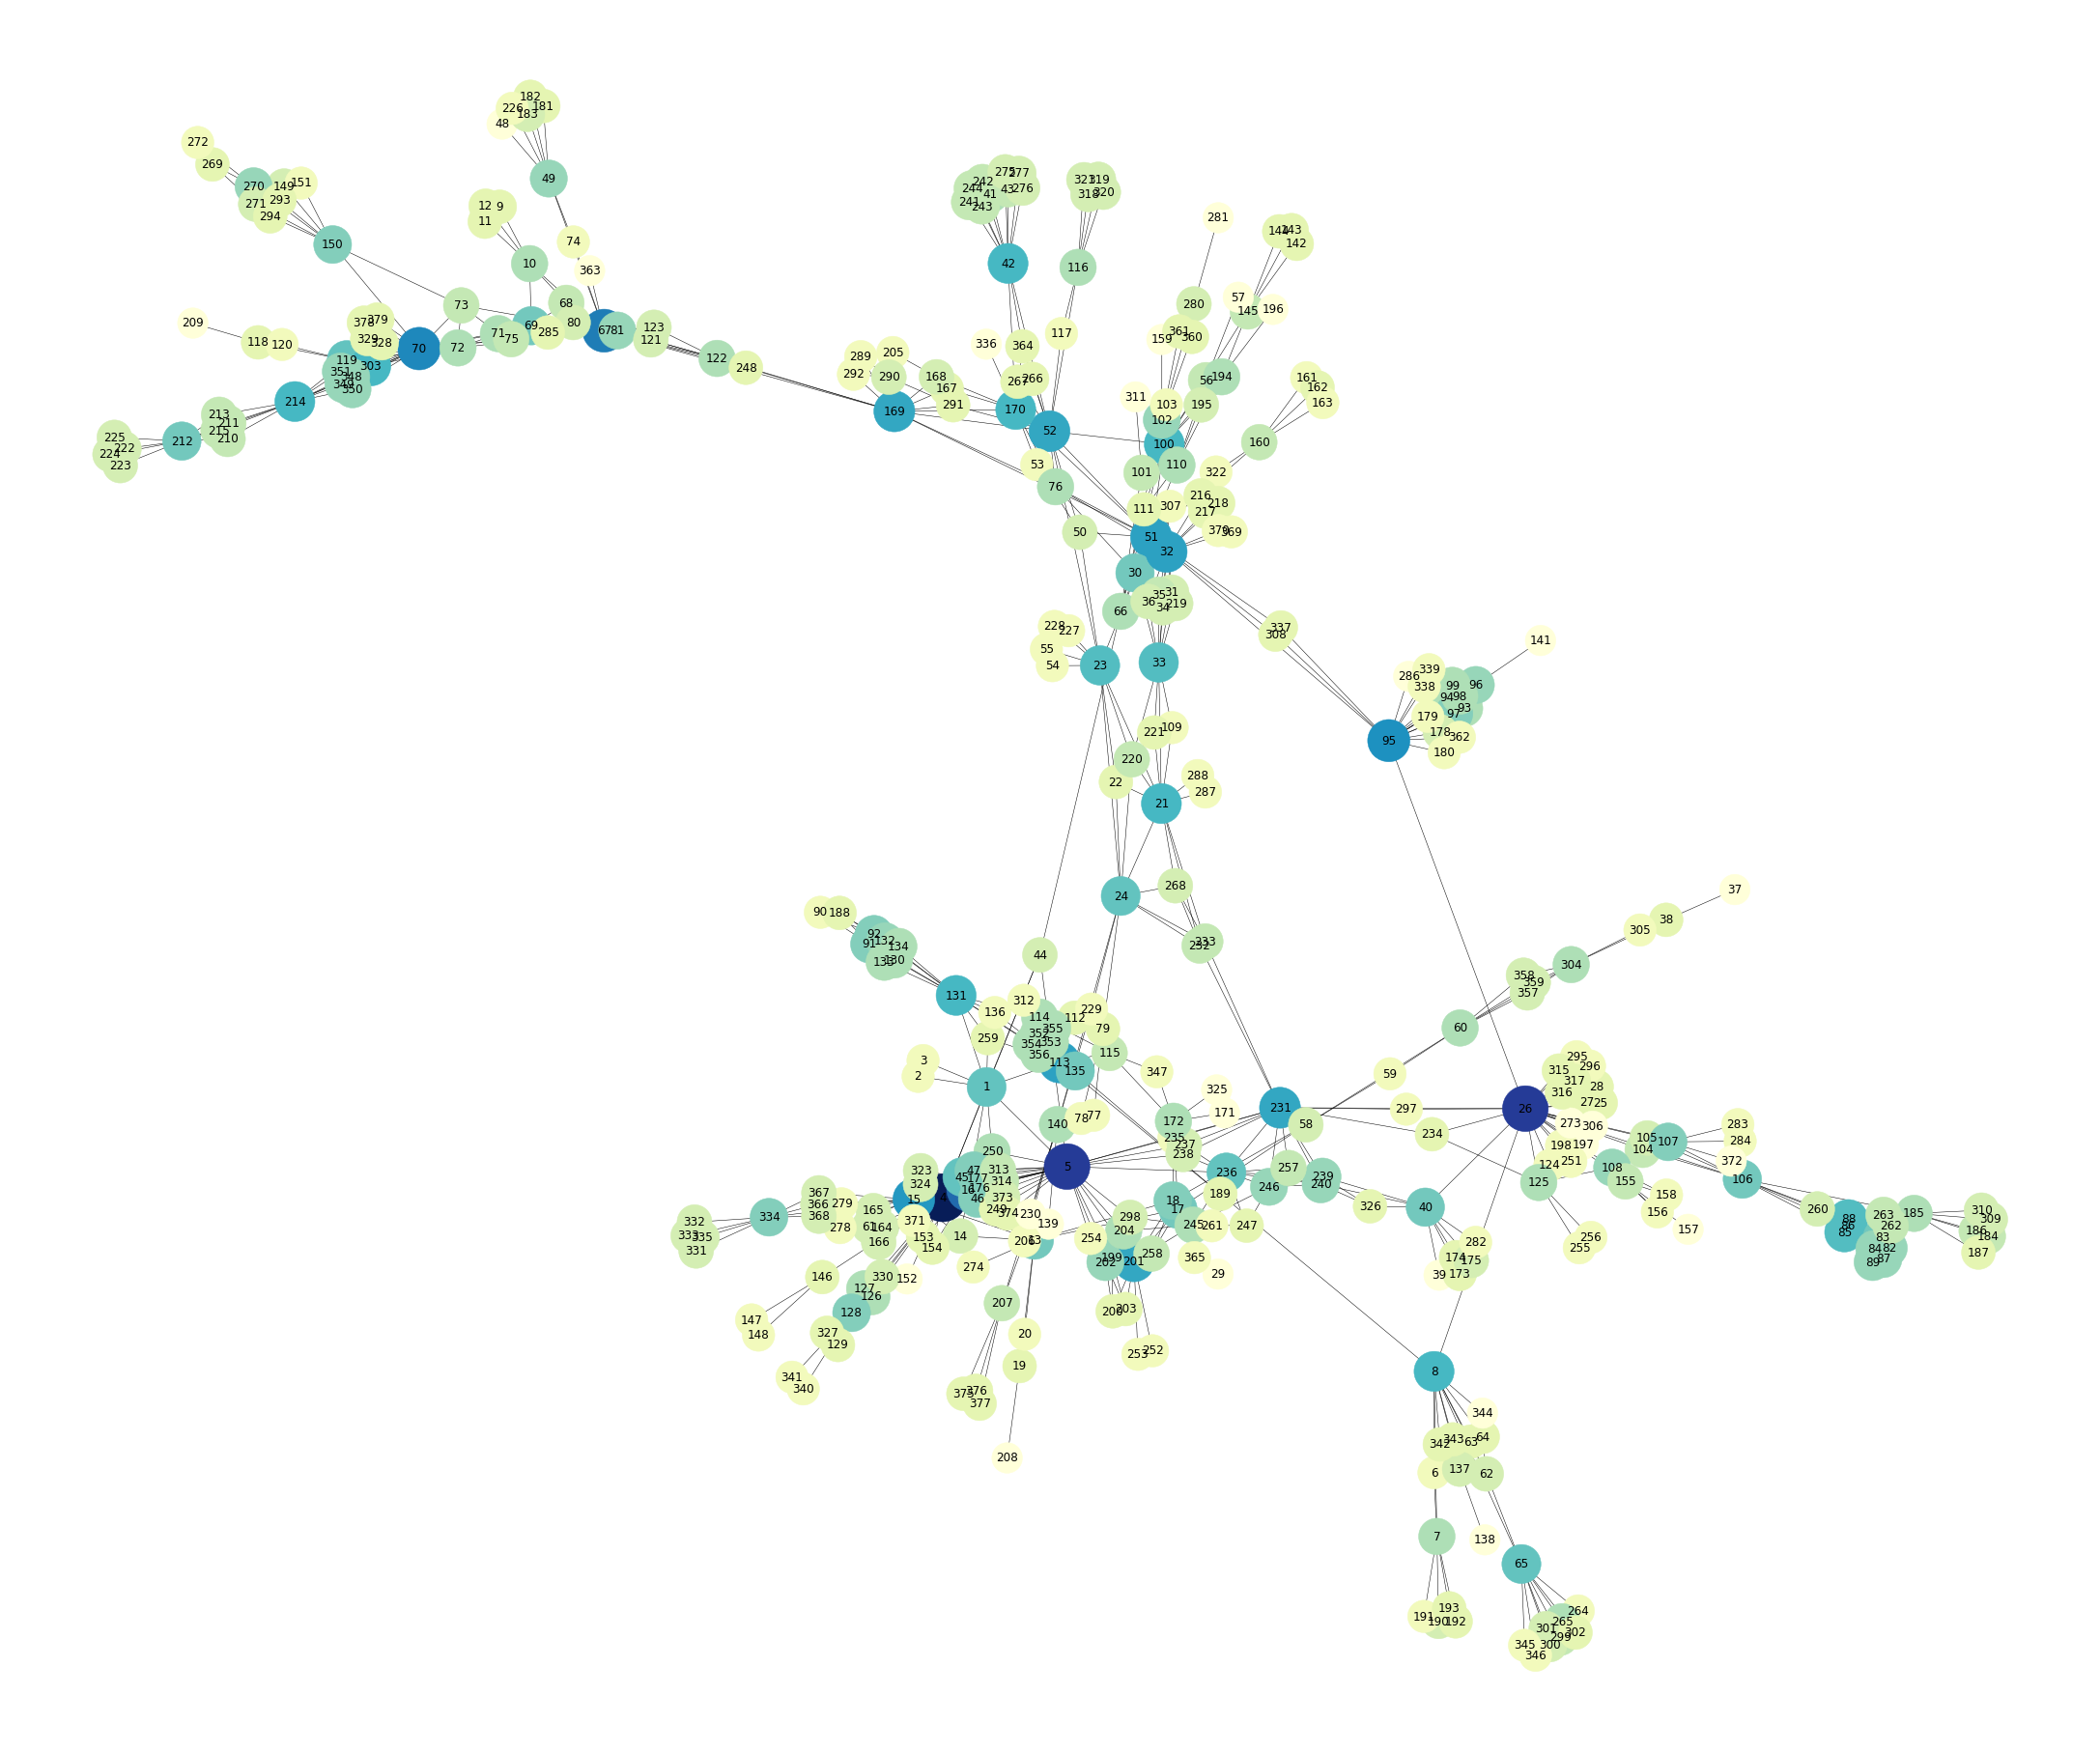

In [124]:
plt.figure(figsize=(30,25))
im2 = draw_(G, pos, np.array(list(nx.degree_centrality(G).values())))